# Exoplanet Vetting with Convolutional Neural Networks

Input data include:
- "Local" view light curve time profile (61 time bins), all 3 aperture depth channels: $X_{\rm local}$, with dimension $n\times 3\times 61$
- "Global" view light curve time profile: $X_{\rm global}$, with dimension $n\times 3 \times 201$
- Depths from local and global light curves, all apertures: $X_{\rm depths}$, with dimension $n\times 6$

Labels y has dimension $n$, each label is either 0 (non-planet) or 1 (planet)

In [1]:
import os
import numpy as np
import h5py
from matplotlib import pyplot as plt
import pickle

import torch
from torch import nn
from torch.nn import (Linear, ReLU, Conv1d, Flatten, Conv2d, Sequential,MaxPool1d, MaxPool2d, Dropout, CrossEntropyLoss)
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

from skimage.io import imread, imshow
from skimage.transform import resize

import sklearn
import sklearn.metrics

Define a function to read some pickled data into numpy array

In [2]:
def read_pickle(filepath):
    
    assert os.path.exists(filepath)
    f = pickle.load(open(filepath,'rb'))    
    
    nfiles = len(f)
    depths = np.zeros((nfiles,6))
    localviews = np.zeros((nfiles,3,61))
    globalviews = np.zeros((nfiles,3,201))
    labels = np.zeros((nfiles,))
    
    for i,file in enumerate(f):
        
        depths[i] = np.hstack([file['LocalDepths'],file['GlobalDepths']])
        localviews[i] = file['LocalView']
        globalviews[i] = file['GlobalView']
        labels[i] = file['label']
        
        localviews[i] /= np.amin(depths[i,[1]], axis = -1,keepdims=True)
        globalviews[i] /= np.amin(depths[i,[4]], axis = -1,keepdims=True)
        
    return depths,localviews,globalviews,labels

Load data $X_{\rm local},X_{\rm global},X_{\rm depths},y$, which contain combined data across multiple sectors. 

In [3]:
verbose = 1
pickle_dir = "/Users/hblim/Dropbox (MIT)/qlp-data/2020_04_27_updatedData/LCpickels/"

all_depths = np.zeros((0,6))
all_localviews = np.zeros((0,3,61))
all_globalviews = np.zeros((0,3,201))
all_labels = np.zeros((0,))

# append with data from each sector
for sector in range(1,23):
    
    filepath = pickle_dir + 'sector-{}.pickle'.format(sector)
    depths,localviews,globalviews,labels = read_pickle(filepath)
    
    all_depths = np.append(all_depths, depths,axis=0)
    all_localviews = np.append(all_localviews, localviews,axis=0)
    all_globalviews = np.append(all_globalviews, globalviews,axis=0)
    all_labels = np.append(all_labels,labels)

if verbose:
    print("X_global.shape = ", all_globalviews.shape)
    print("X_local.shape  = ", all_localviews.shape)
    print("X_depths.shape = ", all_depths.shape)
    print("y.shape        = ", all_labels.shape)

X_global.shape =  (184005, 3, 201)
X_local.shape  =  (184005, 3, 61)
X_depths.shape =  (184005, 6)
y.shape        =  (184005,)


Visualize the data

(202,
 [[<matplotlib.lines.Line2D at 0x1a1f704490>],
 1.0)

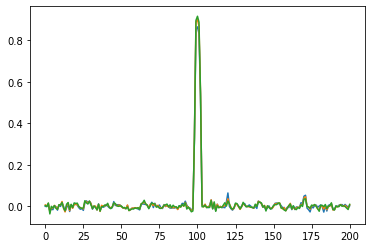

In [4]:
i = np.arange(len(all_labels))[all_labels == 1][11]
i, [plt.plot(all_globalviews[i][j]) for j in range(3)], all_labels[i]

Combine data into single flattened input array 
$X = \lbrace X_{\rm local},X_{\rm global},X_{\rm depths} \rbrace$

Also convert class labels {0 and 1} to {-1 and 1}

In [5]:
verbose = 1
ntotal = len(all_labels)
X = np.zeros((ntotal,0))
X = np.append(X, all_localviews.reshape((ntotal,3*61)),axis=1)
X = np.append(X, all_globalviews.reshape((ntotal,3*201)),axis=1)
X = np.append(X, all_depths.reshape((ntotal,6)),axis=1)

y = np.array(0.5 + all_labels / 2, dtype=int)
if verbose: print("X.shape = ", X.shape)

X.shape =  (184005, 792)


Function to break data into training and testing data

In [80]:
from sklearn.model_selection import StratifiedKFold

def split_data(X,y,n_fold):

    skf = StratifiedKFold(n_splits=5,shuffle=True)

    # currently only using the first fold
    train_i, test_i = next(skf.split(X, y))
    
    Xtrain, ytrain = (X[train_i,:],y[train_i])
    Xtest, ytest = (X[test_i,:],y[test_i])

    return (Xtrain, ytrain), (Xtest, ytest)

To design architecture, helper script to calculate output dimensions given input dimension

In [74]:
padding=0
dilation=1
kernel_size=5
stride=2

Lin = 87
Lout = np.floor((1/stride) * (Lin + 2 * padding - dilation * (kernel_size-1) - 1) + 1)
Lout

42.0

Define Model architecture

In [81]:
class TriInput_Module(nn.Module):
    
    def __init__(self):
        super(TriInput_Module, self).__init__()
        
        # [1] local view input
        self.Local_ModuleList = nn.ModuleList([
            # (C_in, L_in) = (3, 61), 
            nn.Conv1d(in_channels=3, out_channels=16, kernel_size=5),
            # (C_in, L_in) = (16, 57)
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5),
            # (C_in, L_in) = (16, 53), (C_out, L_out) = (16, 24)
            nn.MaxPool1d(kernel_size=7,stride=2)])
        
        # [2] global view input
        self.Global_ModuleList = nn.ModuleList([
            # (C_in, L_in) = (3, 201), 
            nn.Conv1d(in_channels=3, out_channels=16, kernel_size=5),
            # (C_in, L_in) = (16, 197)
            nn.Conv1d(in_channels=16, out_channels=16, kernel_size=5),
            # (C_in, L_in) = (16, 193), 
            nn.MaxPool1d(kernel_size=5,stride=2),
            # (C_out, L_out) = (16, 95), 
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5),
            # (C_out, L_out) = (32, 91), 
            nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5),
            # (C_out, L_out) = (32, 87),(32, 42), 
            nn.MaxPool1d(kernel_size=5,stride=2)])
        
        # [1] + [2] + [3] combined layers
        self.Combined_ModuleList = nn.ModuleList([
            nn.Linear(in_features = (32 * 42 + 16 * 24 + 6), out_features=256),
            nn.Linear(in_features = 256, out_features=256),
            nn.Linear(in_features = 256, out_features=2)])
        
    def forward(self, X):
        X = X.float()
        (N, D) = X.size()
        (Dlocal,Dglobal) = (3 * 61, 3 * 201)
        
        # Exract X -> (Xlocal,Xglobal,Xdepths)
        Xlocal = X[:,0:Dlocal].view(N,3,61)
        Xglobal = X[:,Dlocal:Dlocal+Dglobal].view(N,3,201)
        Xdepths = X[:,Dlocal+Dglobal:].view(N,6)
        
        # Process Xlocal
        for l in self.Local_ModuleList:
            Xlocal = l(Xlocal.float())

        # Process Xglobal
        for l in self.Global_ModuleList:
            Xglobal = l(Xglobal.float())
        
        # Combine with depths 
        X = torch.cat((Xlocal.view(N,16 * 24), 
                       Xglobal.view(N,32*42),
                       Xdepths), 1)
        
        # Process X
        for l in self.Combined_ModuleList:
            X = l(X.float())

        return X.float()

Implement training of model

In [98]:
from sklearn.utils.class_weight import compute_class_weight

def make_deterministic():
    torch.manual_seed(10)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(10)

def weight_reset(l):
    if isinstance(l, Conv2d) or isinstance(l, Linear):
        l.reset_parameters()

def make_iter(X, y, batch_size=1):
    X, y = torch.from_numpy(X), torch.from_numpy(y)
    return DataLoader(TensorDataset(X, y), batch_size=batch_size)

def run_pytorch(train, test, epochs, verbose=True):
    
    make_deterministic()
        
    (X_train, y1), (X_val, y2) = train, test

    # Imbalanced Classes Weights
    weights = torch.FloatTensor(np.array([.5,50]))
    
    # Make Dataset Iterables
    train_iter = make_iter(X_train, y1, batch_size=32)
    val_iter = make_iter(X_val, y2, batch_size=32)
    
    # Model specification
    model = TriInput_Module()

    # Define the optimization
    optimizer = Adam(model.parameters())
    criterion = CrossEntropyLoss(weight=weights)

    # Fit the model
    train_m, vali_m = model_fit(model, train_iter, epochs=epochs, 
                                optimizer=optimizer, criterion=criterion,
                                validation_iter=val_iter,
                                verbose=verbose,history=None)

    (train_loss, train_acc) = train_m
    (vali_loss, val_acc) = vali_m
    
    predict = model(torch.FloatTensor(X_val)).data.numpy()

    return sklearn.metrics.precision_recall_curve(y2, np.amax(predict,axis=1) , pos_label=1)

Fit the model, and udpate parameters

In [99]:
from torch.utils.data import DataLoader, TensorDataset
import itertools

def model_fit(model, train_iter, epochs, optimizer, criterion,
              validation_iter, history, verbose, model_reg=None):

    av_train_loss, av_train_acc, av_vali_loss, av_vali_acc = [], [], [], []
    for epoch in range(epochs):
        train_loss, train_acc_score = call_model('train', model, train_iter, optimizer, criterion, model_reg=model_reg)
        vali_loss, vali_acc_score  = call_model('vali', model, validation_iter, optimizer, criterion)
        if verbose: print("epoch: {} | TRAIN: loss {} acc {} | VALI: loss {} acc {}".format(epoch,
                                                                 round(train_loss, 5), 
                                                                 round(train_acc_score, 5), 
                                                                 round(vali_loss, 5), 
                                                                 round(vali_acc_score, 5)))
        if history is not None:
            history['epoch_loss'].append(train_loss)
            history['epoch_val_loss'].append(vali_loss)
            history['epoch_acc'].append(train_acc_score)
            history['epoch_val_acc'].append(vali_acc_score)

        av_train_loss.append(train_loss)
        av_train_acc.append(train_acc_score)
        av_vali_loss.append(vali_loss)
        av_vali_acc.append(vali_acc_score)
    
    return ((np.mean(av_train_loss), np.mean(av_train_acc)), (np.mean(av_vali_loss), np.mean(av_vali_acc)))

def call_model(mode, model, data_iter, optimizer, criterion, model_reg=None):
    epoch_loss = []
    hits = []
    items = []
    
    # This is to manually regularize model, should return a value that is 
    # a function of the model parameters.
    if model_reg == None:
        model_reg = lambda x: 0

    if mode == 'train':
        model.train()
        grad_mode = torch.enable_grad()
    else:
        model.eval()
        grad_mode = torch.no_grad()

    with grad_mode:

        for batch in data_iter:
            X, y = batch

            if mode == 'train':
                # zero the parameter gradients
                optimizer.zero_grad()

            # forward
            y_hat = model(X.float()).float()

            batch_loss = criterion(y_hat.float(), y.long()) + model_reg(model)

            if mode == 'train':
                # backward + optimize
                batch_loss.backward()
                optimizer.step()

            epoch_loss.append(batch_loss.item())
            if type(criterion) == CrossEntropyLoss:
                hits.append((y_hat.argmax(1) == y.long()).sum())
            else:
                hits.append((((y_hat - y.float()) ** 2.).sum().item()))
            items.append(X.shape[0])

        loss = np.sum(epoch_loss)/np.sum(items)
        acc_score = np.sum(hits)/np.sum(items)
        return loss, acc_score

Execute on data

In [100]:
import time
train, test = split_data(X,y,5)

t0 = time.time()
precision_recall = run_pytorch(train, test, 1, verbose=True)
tf = time.time() - t0
print("Run time: {:.2f} seconds".format(tf))

epoch: 0 | TRAIN: loss 228.33988 acc 0.90089 | VALI: loss 0.40338 acc 0.80405
Run time: 136.88 seconds


(0, 0.01)

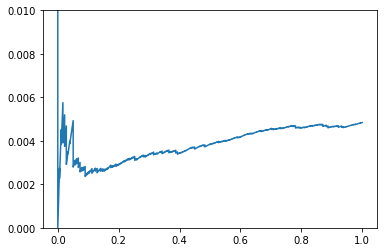

In [101]:
plt.plot(precision_recall[1],precision_recall[0])
plt.ylim([0,.01])